In [1]:
library(extrafont)
library(tidyverse)
library(epidemia)
library(arrow)

Registering fonts with R

── Attaching core tidyverse packages ───────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ─────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘arrow’


The following object is masked from ‘package:lubridate’:

    duration


The following object is masked from ‘package:utils’:

    timestamp




# 1. parameters

In [2]:
T0 = 40

## observation parameters

In [3]:
alpha = 0.01

$$Y_t = NegBinom( \frac{EY_t}{r_Y + EY_t}, r_Y )$$

$$ EY_t = \alpha\sum_{s=1}^{t-1} I_s \pi_{t-s} $$

## latent parameters

In [4]:
K = 6.5

$$I_t = NegBinom( \frac{EI_t}{r_I + EI_t}, r_I )$$

$$ EI_t = R(\bar{A}_t, \beta) \sum_{s=1}^{t-1} I_s g_{t-s} $$

$$R(\bar{A}_t, \beta) = \frac{K}{1+\exp(- \beta^\top A_t)}$$

## seed values

$$I_{-T_0} = \mu_0$$

In [5]:
param <- read_feather('data/param_ebcr_0.feather')

In [6]:
names(param) <- c('region', 'mu', 'beta0', 'beta1')

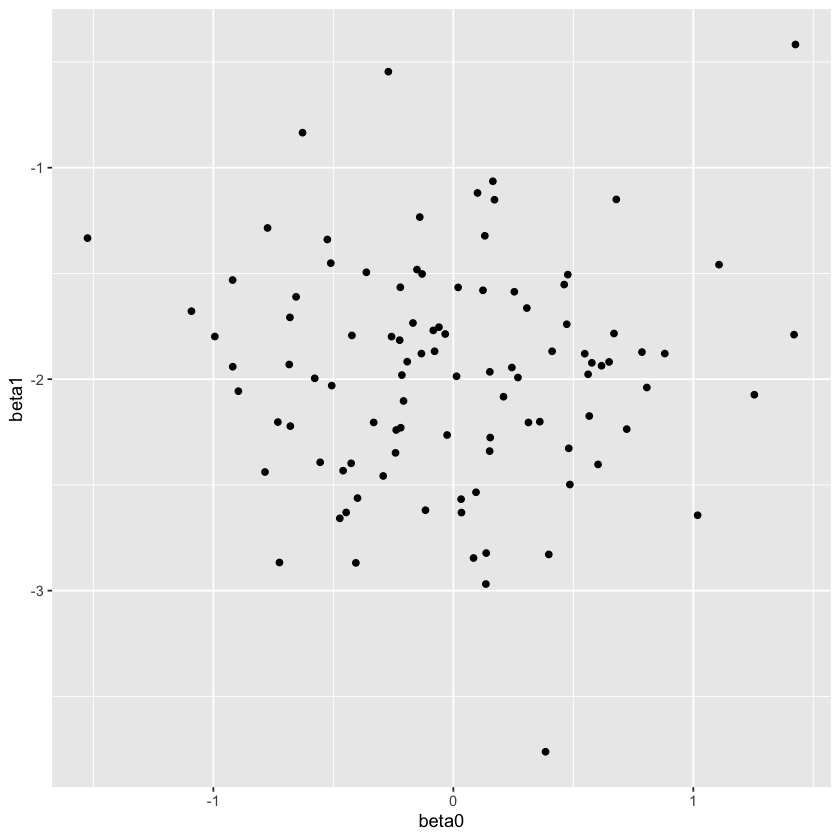

In [7]:
ggplot(param, aes(x=beta0, y=beta1)) + geom_point()

# 2. load simulation data

In [8]:
data <- read_feather('data/simulation_ebcr_0.feather')

In [9]:
data$date = as.Date("2022-01-01") + data$date

In [10]:
data = data %>% group_by(region) %>% group_modify(~ {
    data.frame(date = c(min(.x$date)+(-T0:-1), .x$date),
               death = c(rep(NA,T0), .x$death),
               intervention = c(rep(0,T0), .x$intervention))}
)

In [11]:
head(data)

region,date,death,intervention
<chr>,<date>,<int>,<dbl>
aa,2021-11-22,NA,0
aa,2021-11-23,NA,0
aa,2021-11-24,NA,0
aa,2021-11-25,NA,0
aa,2021-11-26,NA,0
aa,2021-11-27,NA,0


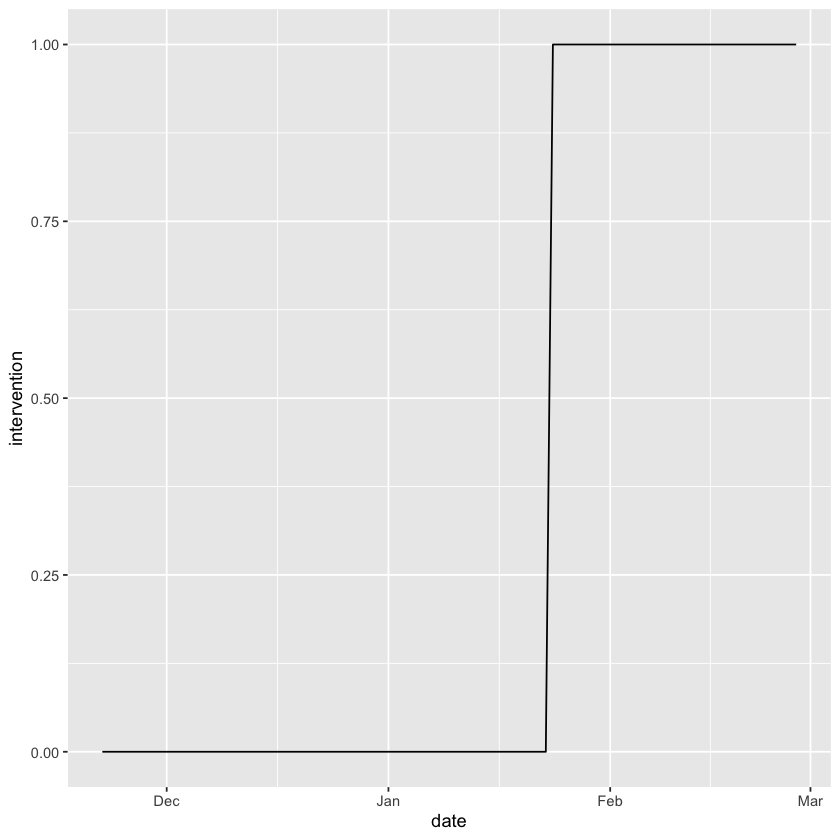

In [12]:
options(repr.plot.width = 7, repr.plot.height = 7)
ggplot(data %>% filter(region == param$region[4]), aes(x=date, y=intervention)) + geom_line()

Warning message:
“Removed 40 rows containing missing values (`geom_line()`).”


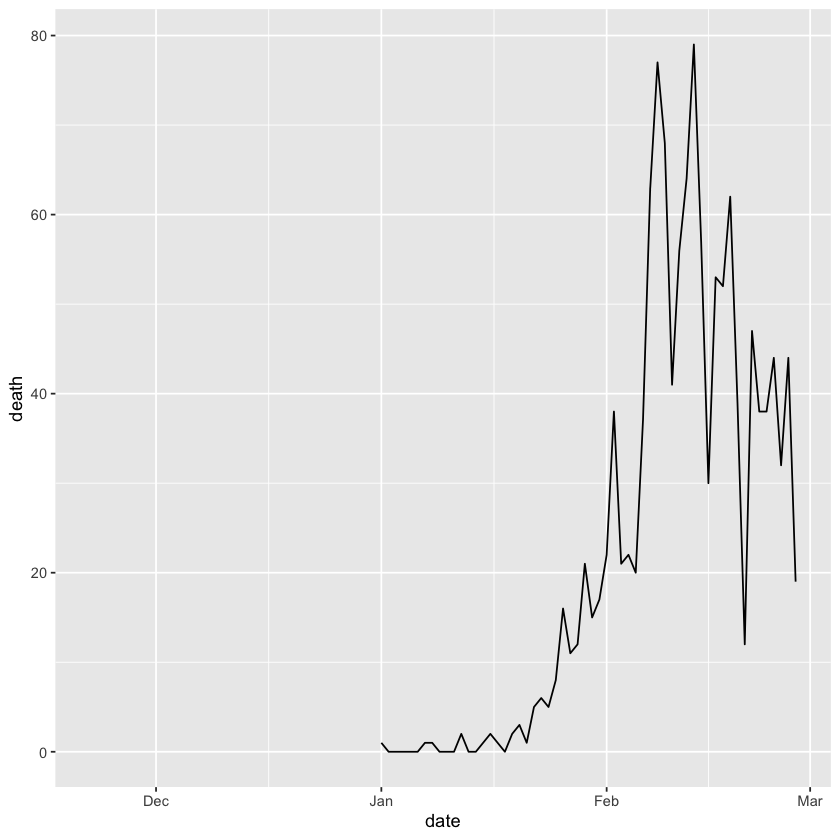

In [13]:
options(repr.plot.width = 7, repr.plot.height = 7)
ggplot(data %>% filter(region == param$region[4]), aes(x=date, y=death)) + geom_line()

# 2. fit

In [14]:
rt <- epirt(formula = R(region, date) ~ 1 + intervention
            + (1 + intervention || region),
            prior = shifted_gamma(shape = 1/6, scale = 1, shift = log(1.05)/6),
            prior_covariance = decov(shape = c(2, 0.5), scale = 0.25),
            link = scaled_logit(K))

In [15]:
inf <- epiinf(gen = EuropeCovid$si, seed_days = T0)

In [16]:
deaths <- epiobs(formula = death ~ 1, i2o = EuropeCovid2$inf2death,
                 prior_intercept = normal(0, 0.01), link = scaled_logit(2*alpha))

Warning message:
“i2o does not sum to one. Please ensure this is intentional.”


In [17]:
args <- list(rt = rt, inf = inf, obs = deaths, data = data, 
             seed=12345, refresh=0)

In [18]:
args$algorithm <- "fullrank"; args$iter <- 5e4; args$tol_rel_obj <- 1e-3

In [19]:
fm <- do.call(epim, args)

Warning message:
“Pareto k diagnostic value is 58.79. Resampling is disabled. Decreasing tol_rel_obj may help if variational algorithm has terminated prematurely. Otherwise consider using sampling instead.”


In [20]:
as.data.frame(fm$stanfit)

R|(Intercept),R|intervention,R|b[(Intercept) region:aa],R|b[(Intercept) region:ab],R|b[(Intercept) region:ac],R|b[(Intercept) region:ad],R|b[(Intercept) region:ae],R|b[(Intercept) region:af],R|b[(Intercept) region:ag],R|b[(Intercept) region:ah],⋯,seeds[dp],seeds[dq],seeds[dr],seeds[ds],seeds[dt],seeds[du],seeds[dv],seeds_aux,death|reciprocal dispersion,log-posterior
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
-0.0240713,-0.913664,-0.561327,0.2633240,-0.726295,-0.16119200,-0.0914390,-0.549193,-0.13740700,-0.2220240,⋯,222.8820,389.305,140.6760,488.551,625.073,326.137,653.336,187.3180,10.2369,0
0.1449720,-0.756461,-0.507863,-0.0697432,-0.568755,-0.28573200,-0.2196410,-0.447405,0.02532470,-0.2844310,⋯,203.7900,404.365,120.0160,311.820,448.232,390.513,800.847,182.9430,10.2857,0
0.3600770,-1.104140,-0.482401,-0.1122340,-0.672407,-0.20638800,-0.3198200,-0.514122,0.15768700,-0.3535600,⋯,177.9970,1186.900,132.2880,196.222,267.154,514.225,467.604,122.3390,10.2261,0
-0.0401858,-0.971920,-0.527202,-0.0531059,-0.518135,-0.04111830,-0.1084230,-0.625102,0.10935800,-0.2626970,⋯,261.8170,1100.550,120.6720,300.492,444.545,392.177,606.974,348.4880,10.1910,0
0.2986100,-1.008610,-0.515848,0.0711673,-0.593044,-0.14011800,-0.3539710,-0.462053,0.04398120,-0.4279040,⋯,124.4630,834.651,130.9350,301.199,363.364,335.765,972.634,252.9260,10.2479,0
0.4797690,-1.449040,-0.413804,-0.1992120,-0.861652,-0.38942200,-0.4733760,-0.381597,0.16031900,-0.6639170,⋯,116.0700,940.063,86.1525,178.415,177.090,219.376,404.198,338.9520,10.2187,0
0.2259750,-1.370080,-0.564372,-0.4782910,-0.592753,-0.09782160,0.0312853,-0.730351,0.00306435,-0.2554200,⋯,249.2980,482.836,116.3530,210.917,374.199,321.314,608.065,475.4110,10.1710,0
-0.2538240,-0.864212,-0.497002,0.1667080,-0.362656,-0.26480700,-0.3408210,-0.404538,0.00185903,-0.0350147,⋯,296.6670,557.384,216.9040,410.872,470.302,525.604,665.337,411.2730,10.1533,0
0.5492750,-0.588939,-0.914729,-0.2041390,-0.659769,-0.45314600,-0.4739520,-0.653377,-0.34722500,-0.5778470,⋯,122.5980,564.238,109.9520,325.771,259.241,248.088,371.541,134.5810,10.2465,0


In [21]:
write_feather(as.data.frame(fm$stanfit), 
              'result_epidemia_ebcr_0.feather')

## plots

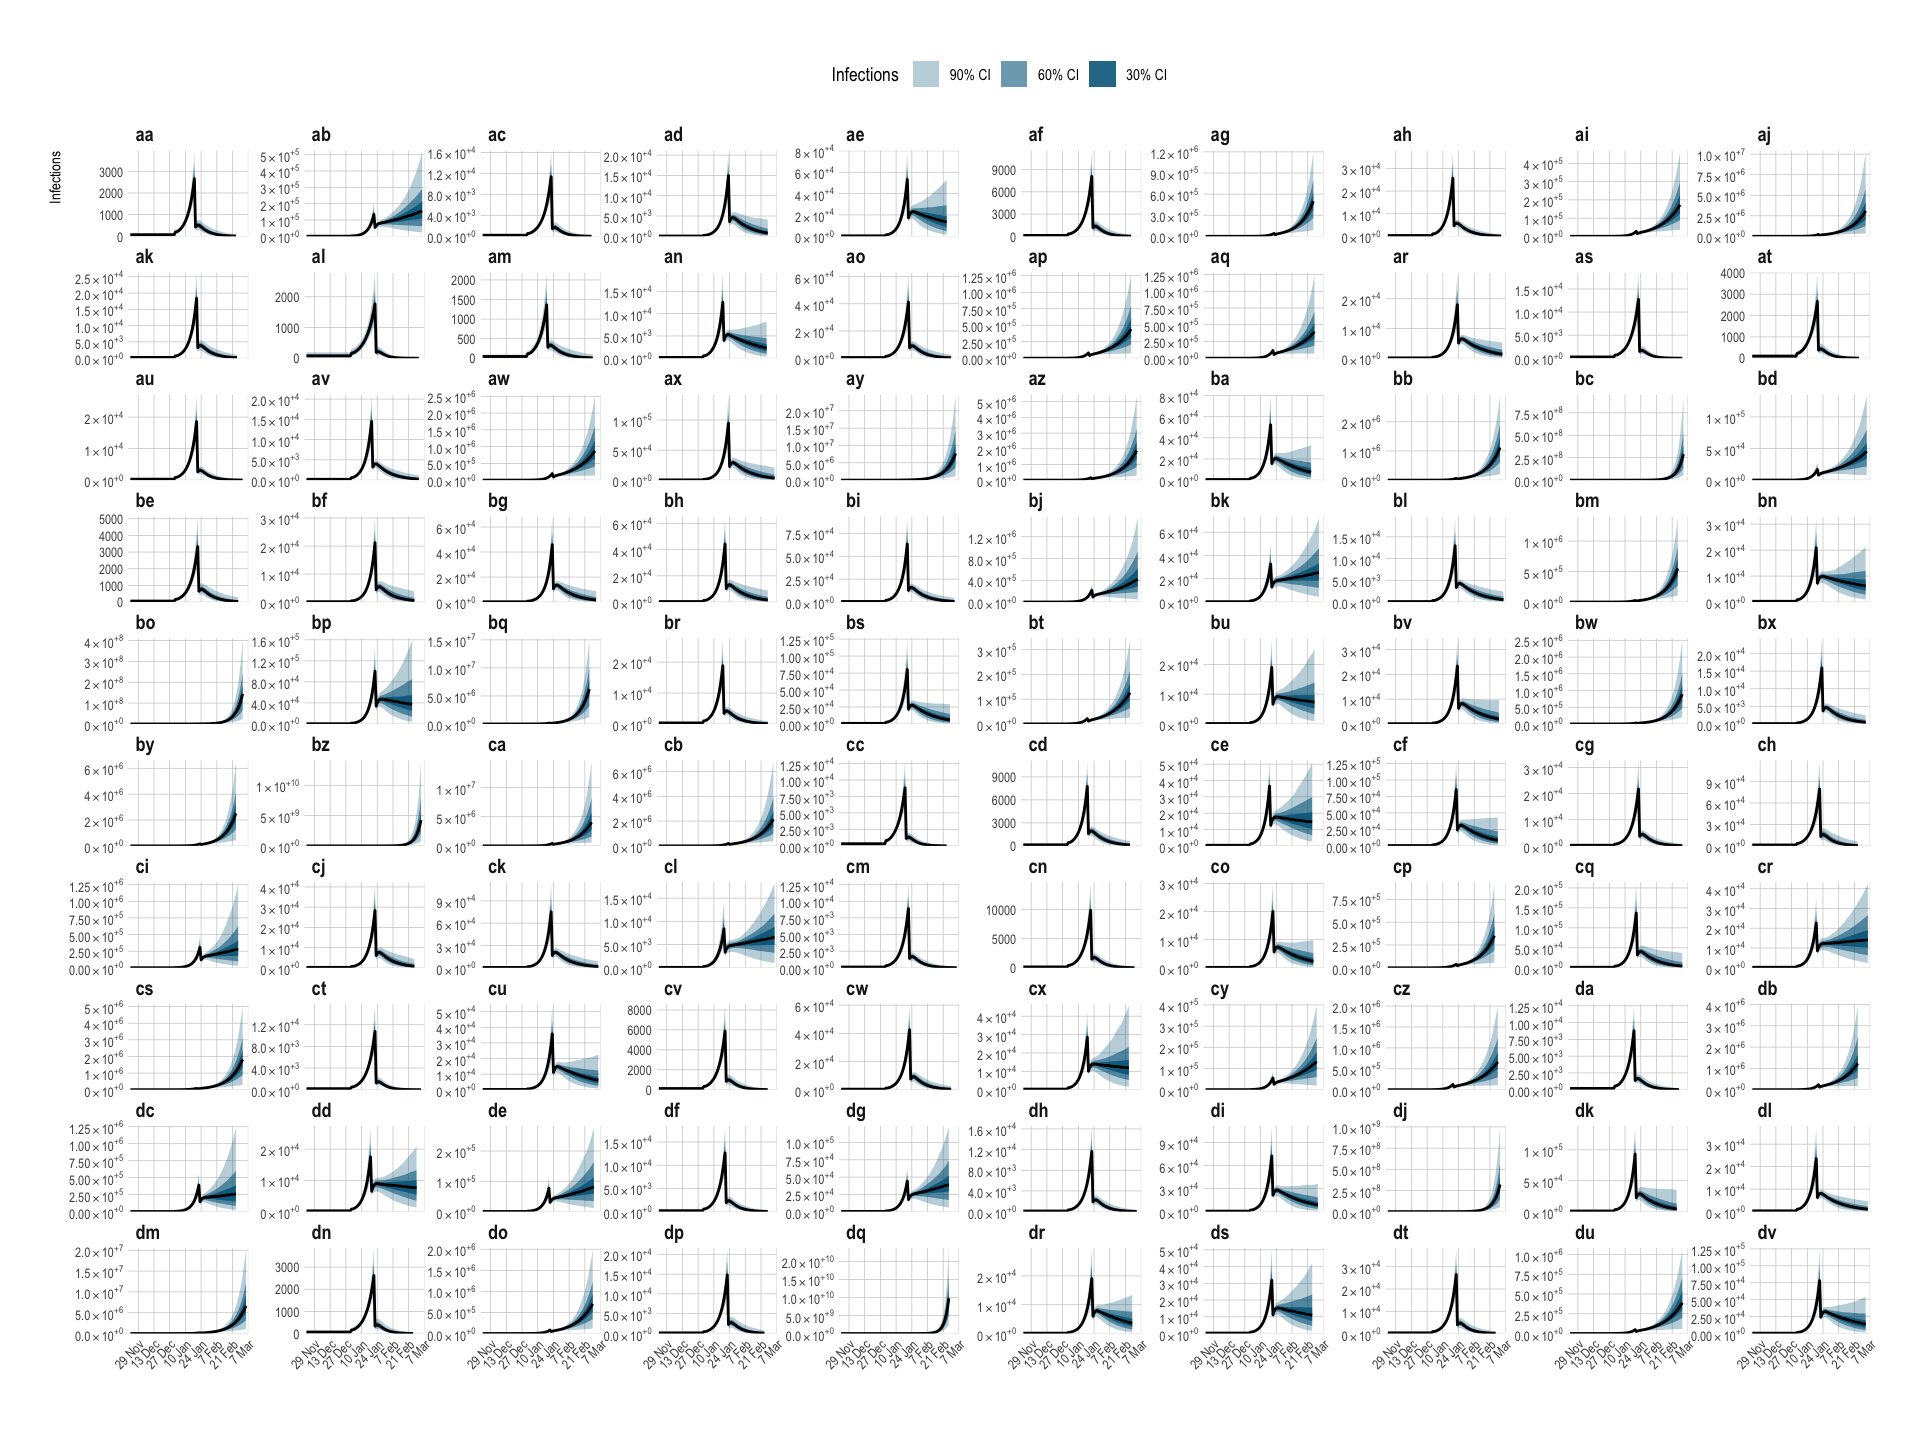

In [ ]:
options(repr.plot.width = 16, repr.plot.height = 12)
plot_infections(fm, type="death")

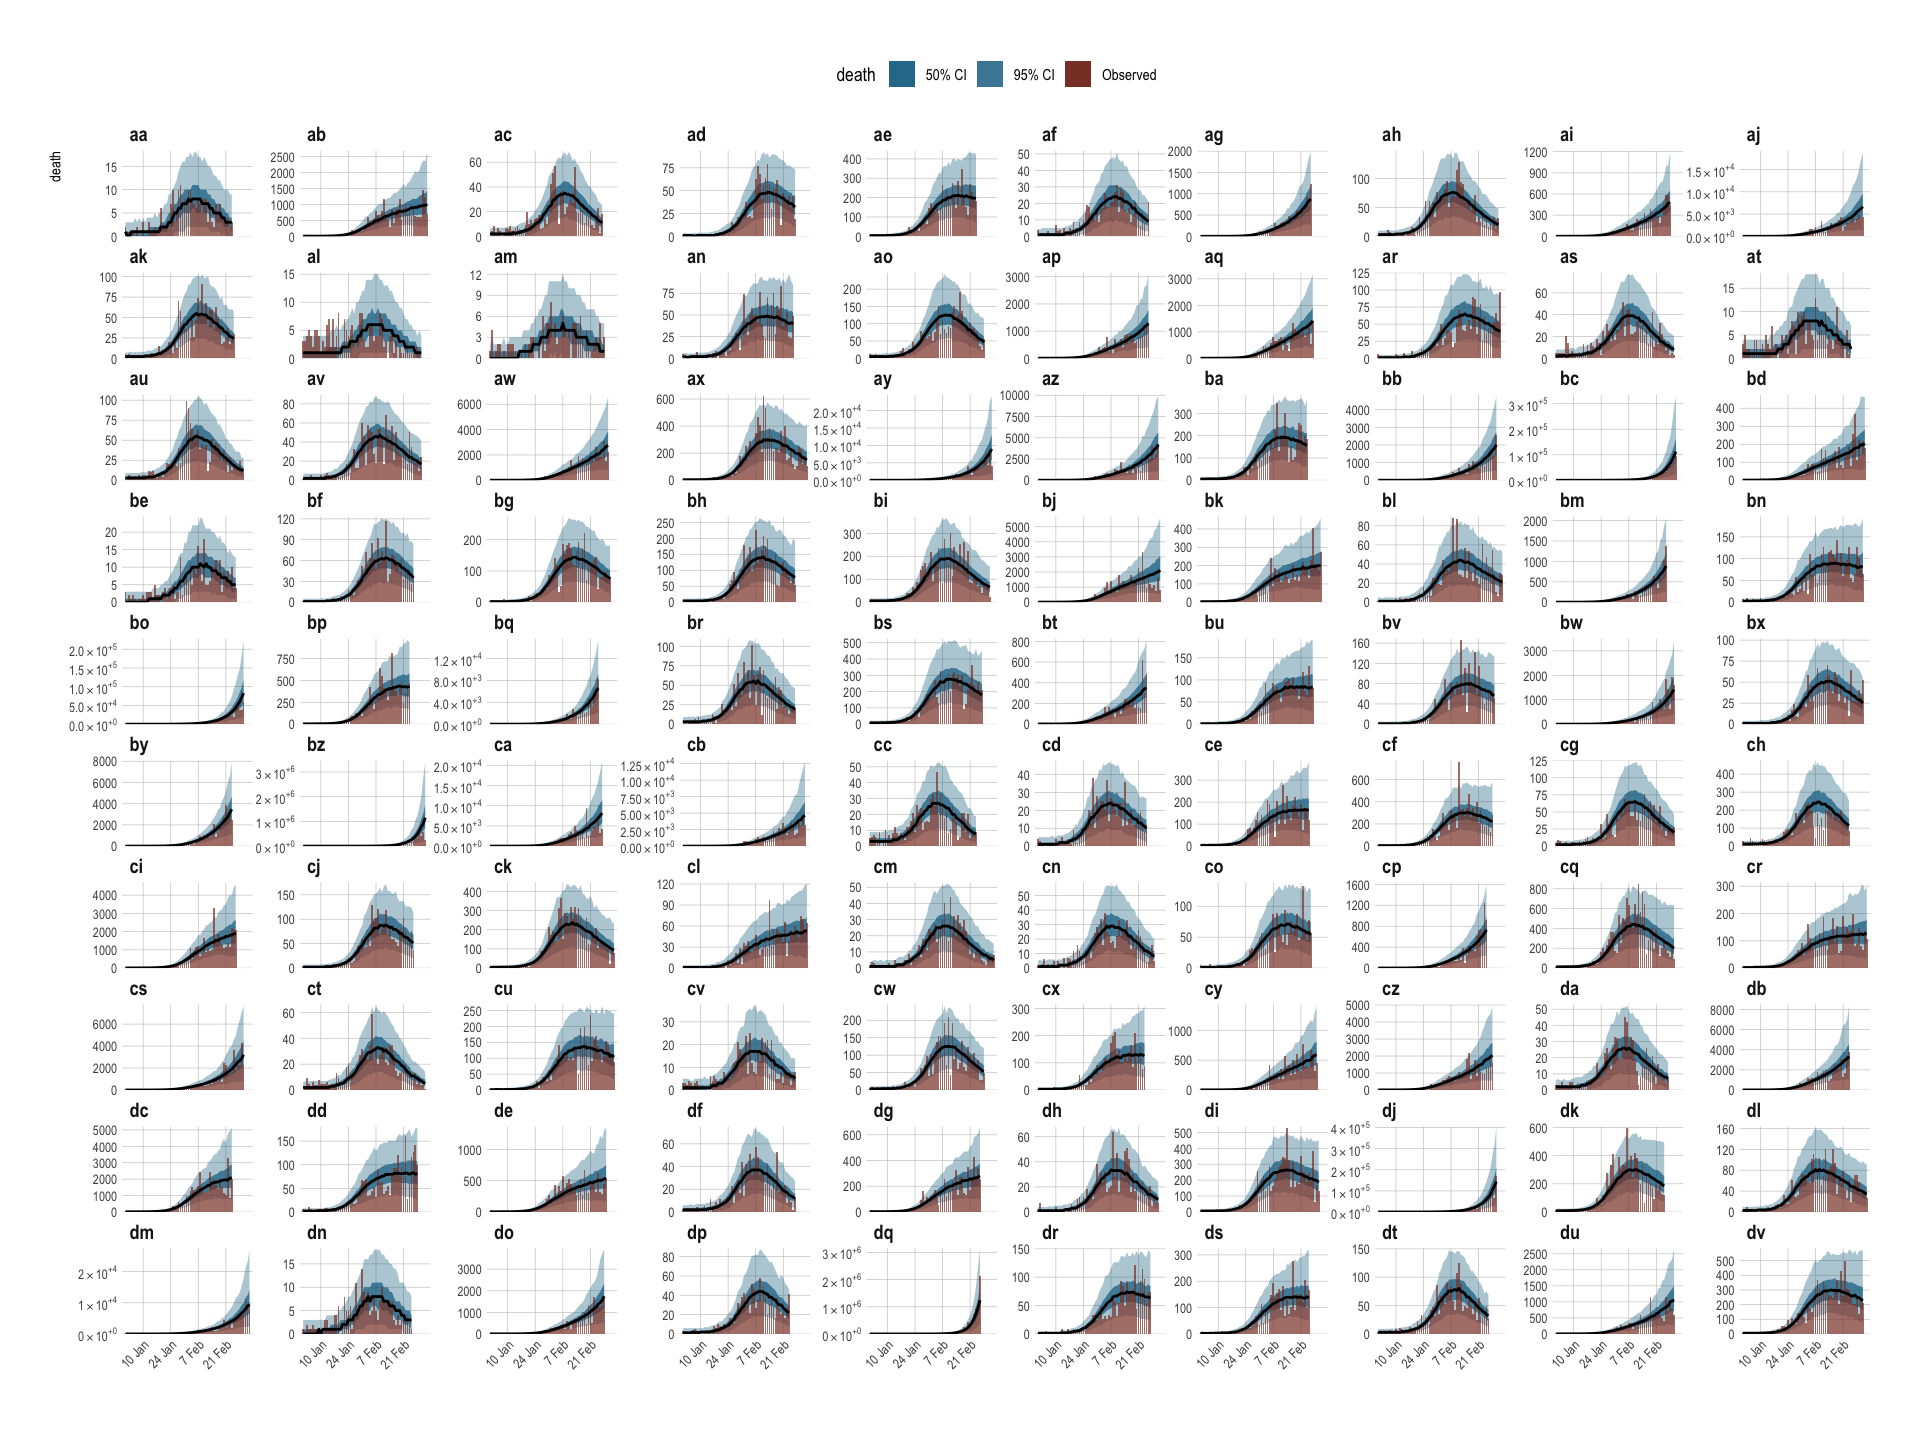

In [23]:
options(repr.plot.width = 16, repr.plot.height = 12)
plot_obs(fm, type="death", levels = c(50, 95))

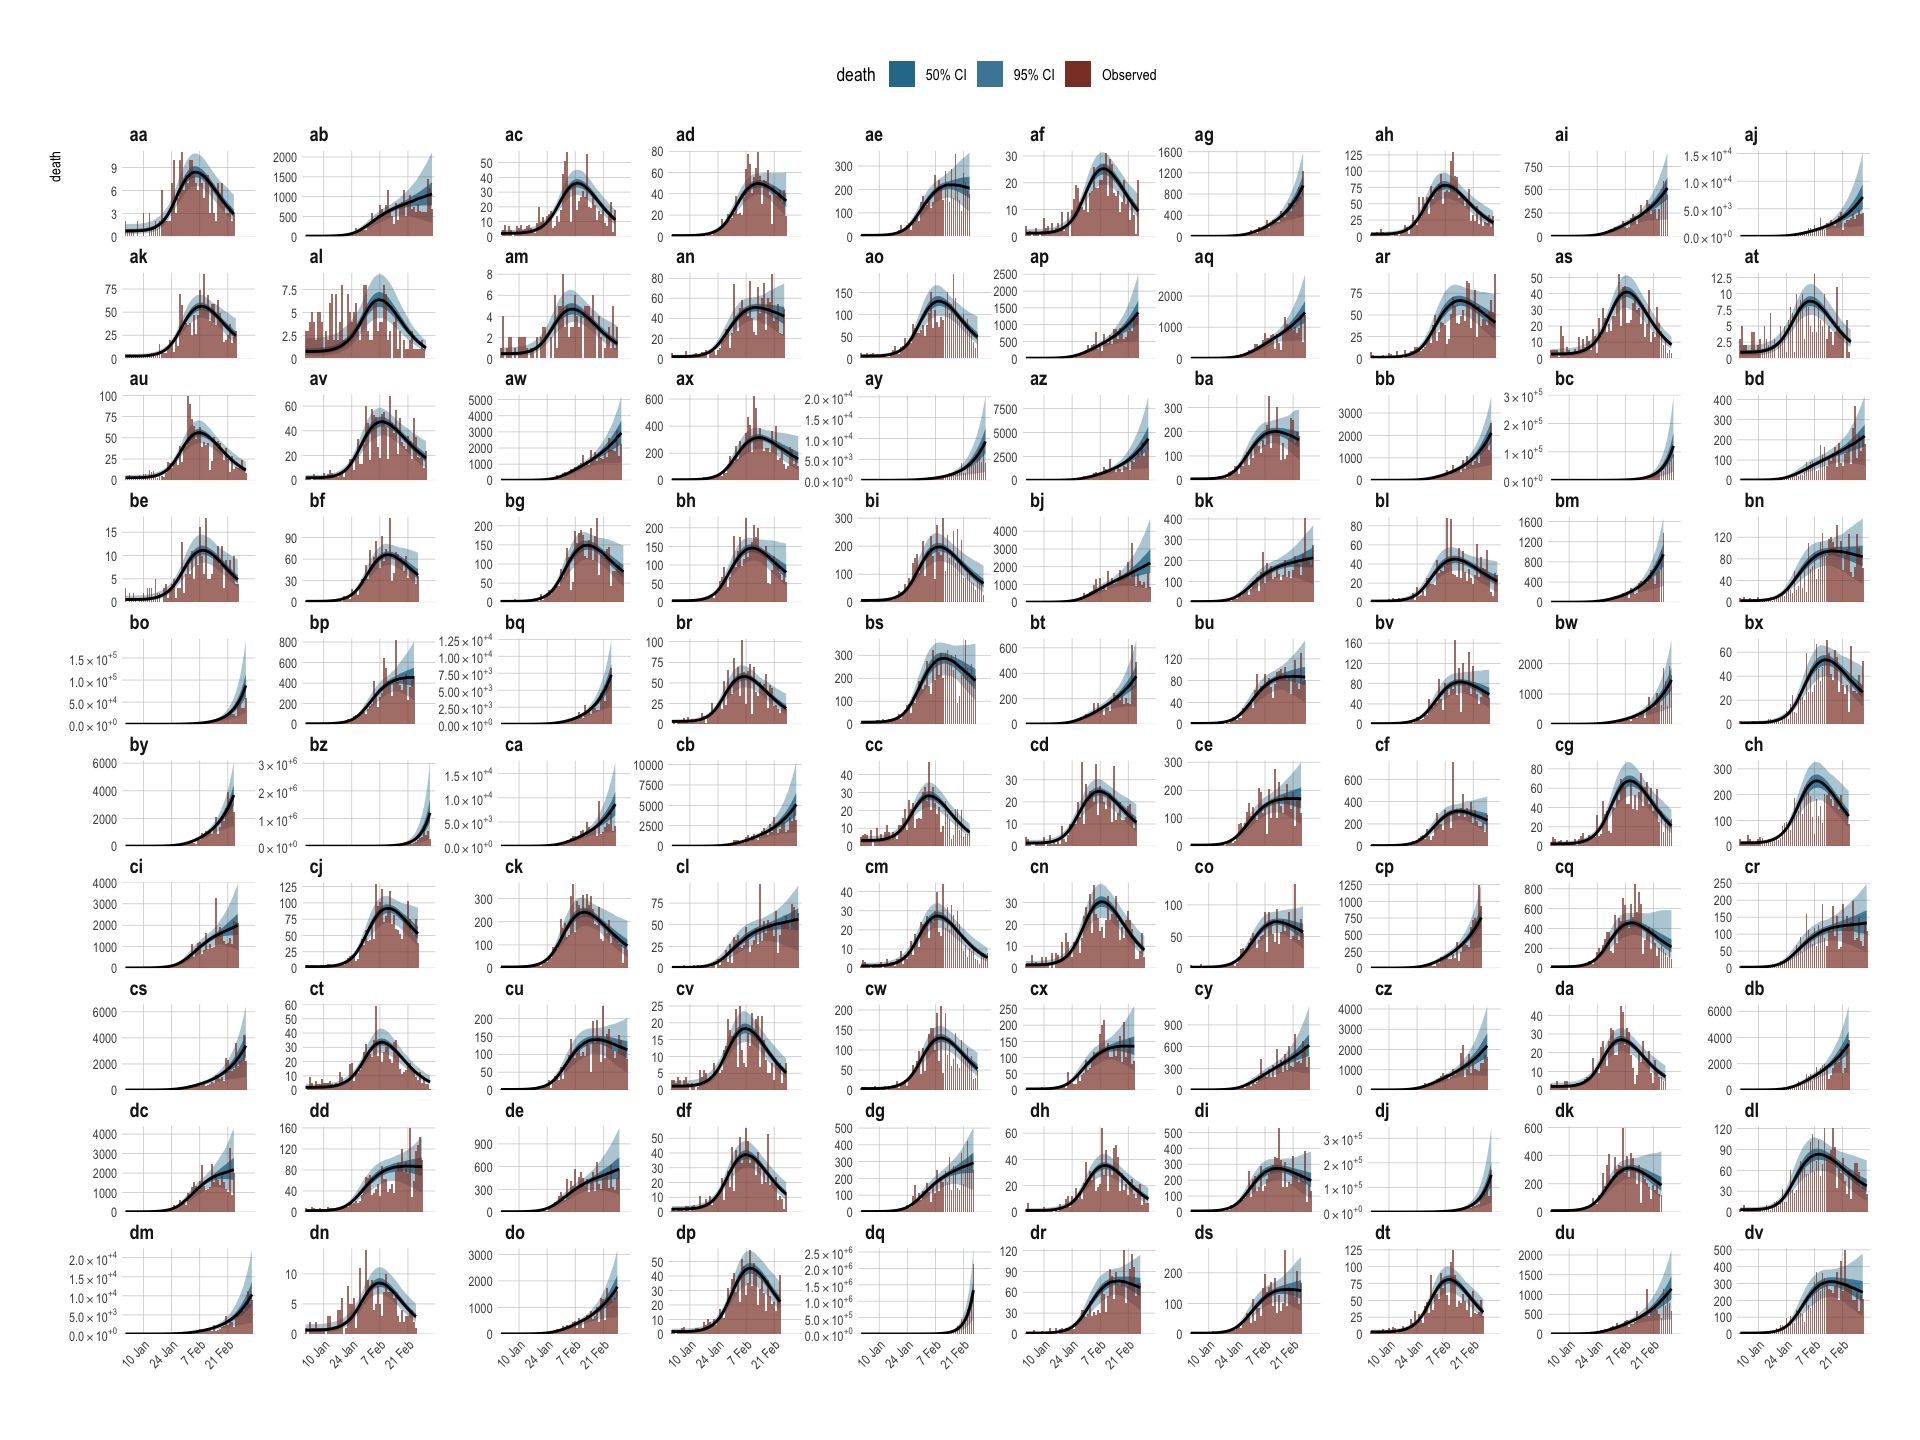

In [24]:
options(repr.plot.width = 16, repr.plot.height = 12)
plot_obs(fm, type="death", levels = c(50, 95), posterior_mean=TRUE)

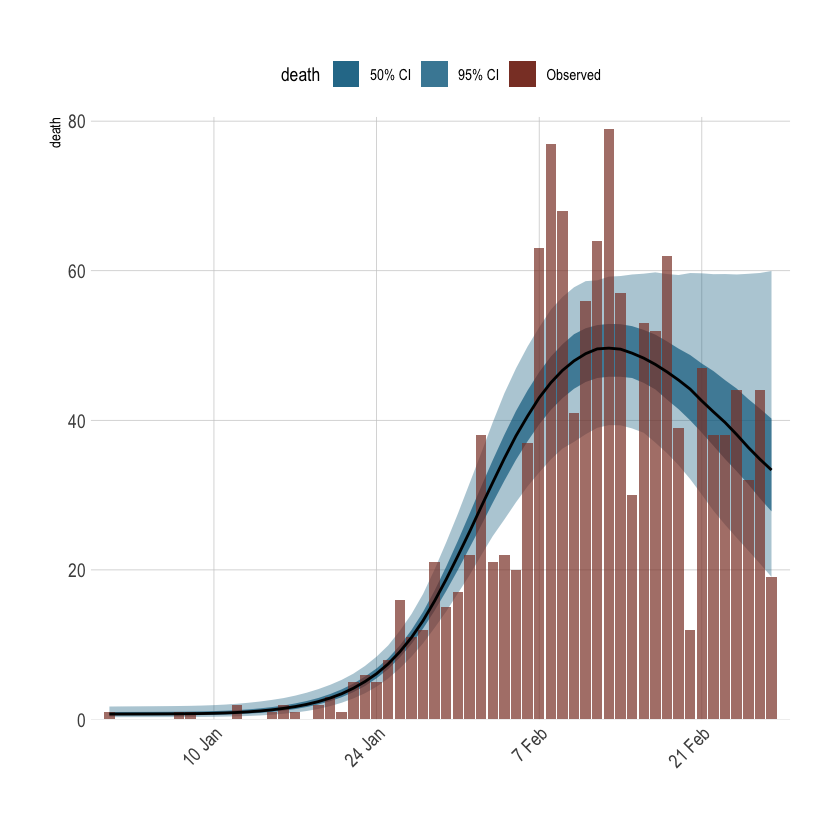

In [25]:
options(repr.plot.width = 7, repr.plot.height = 7)
plot_obs(fm, type="death", group = param$region[4], levels = c(50, 95), posterior_mean=TRUE)

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


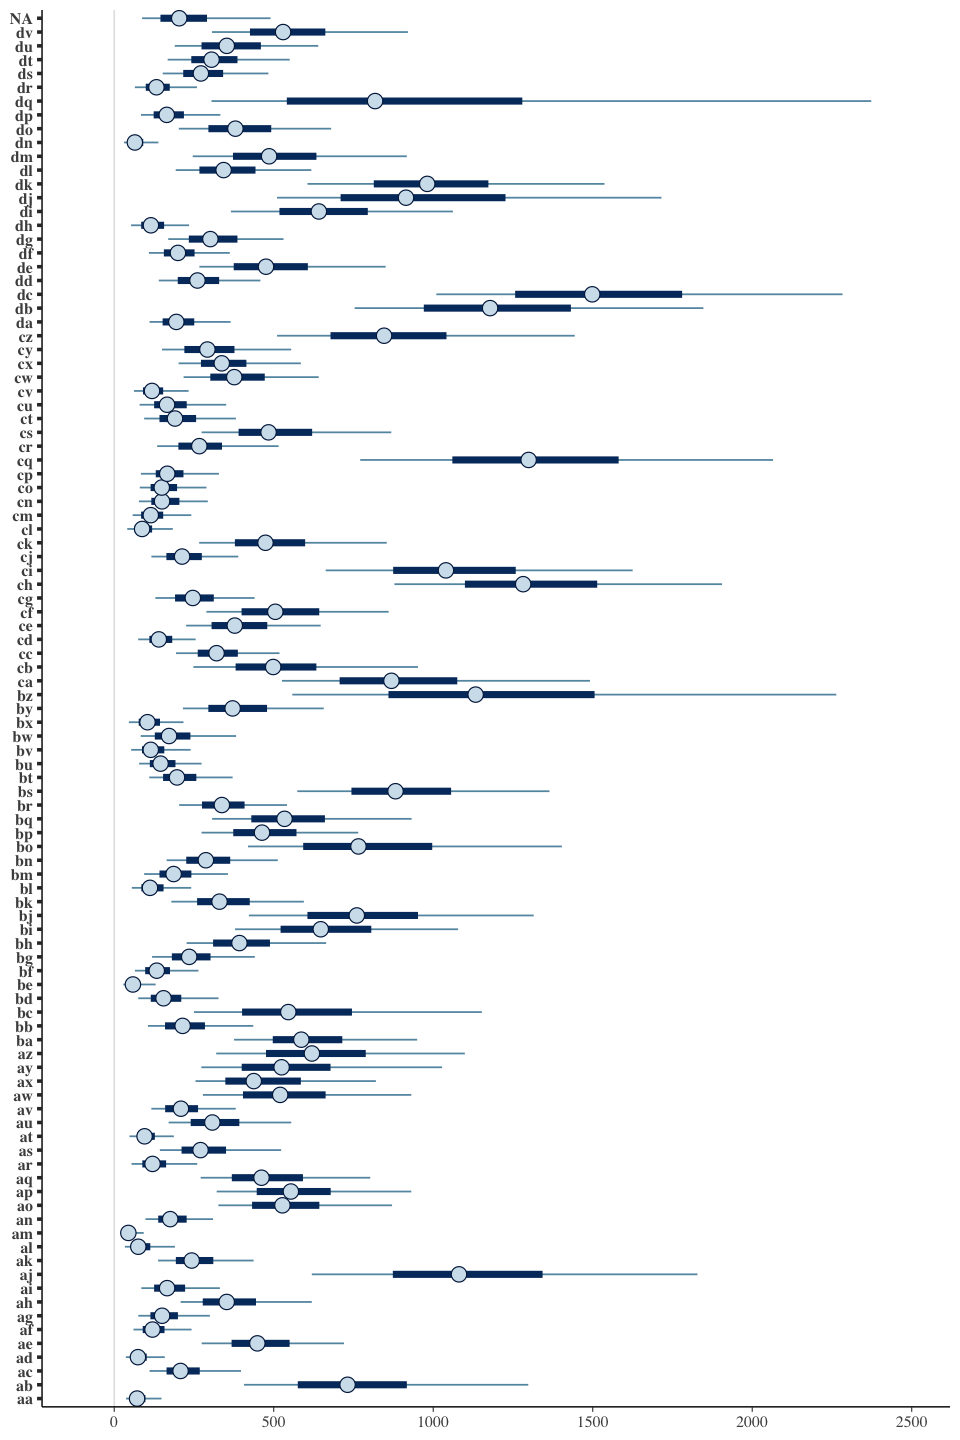

In [26]:
options(repr.plot.width = 8, repr.plot.height = 12)

mat <- as.matrix(fm, "areas", regex_pars = "seeds", par_groups = fm$groups)
bayesplot::mcmc_intervals(mat) + scale_y_discrete(labels=fm$groups)

In [27]:
m_epi = apply(mat, 2, mean)

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


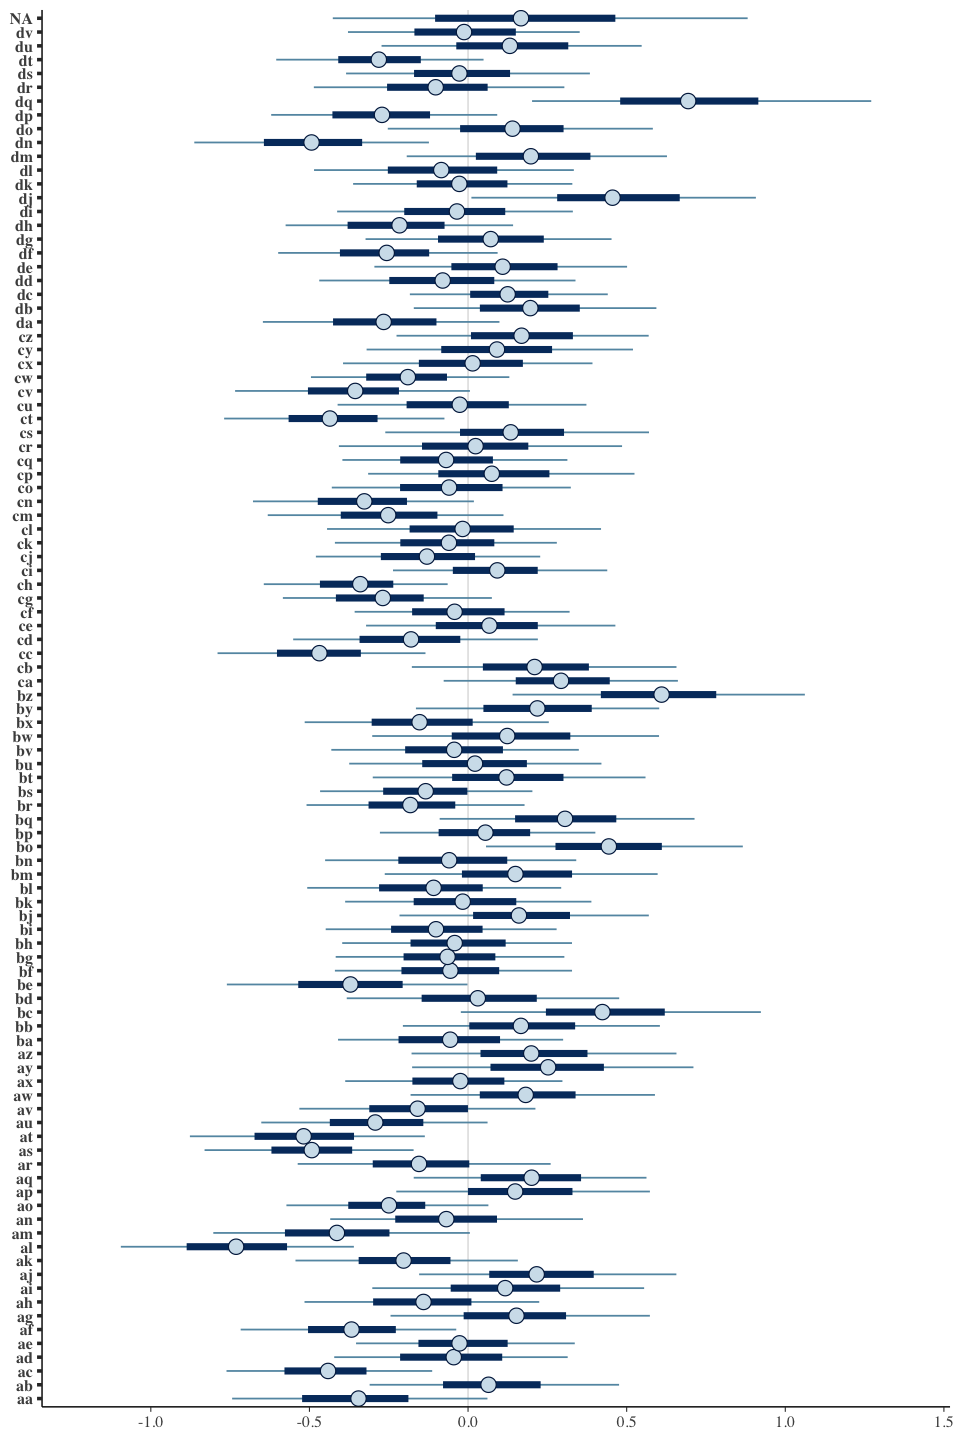

In [28]:
options(repr.plot.width = 8, repr.plot.height = 12)

beta <- as.matrix(fm, regex_pars = "R\\|\\(Int")
b <- as.matrix(fm, regex_pars = "R\\|b\\[\\(Int")
mat <- sweep(b, MARGIN=1, STATS = beta, FUN = "+")

bayesplot::mcmc_intervals(mat) + scale_y_discrete(labels=fm$groups)

In [29]:
b0_epi = apply(mat, 2, mean)

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


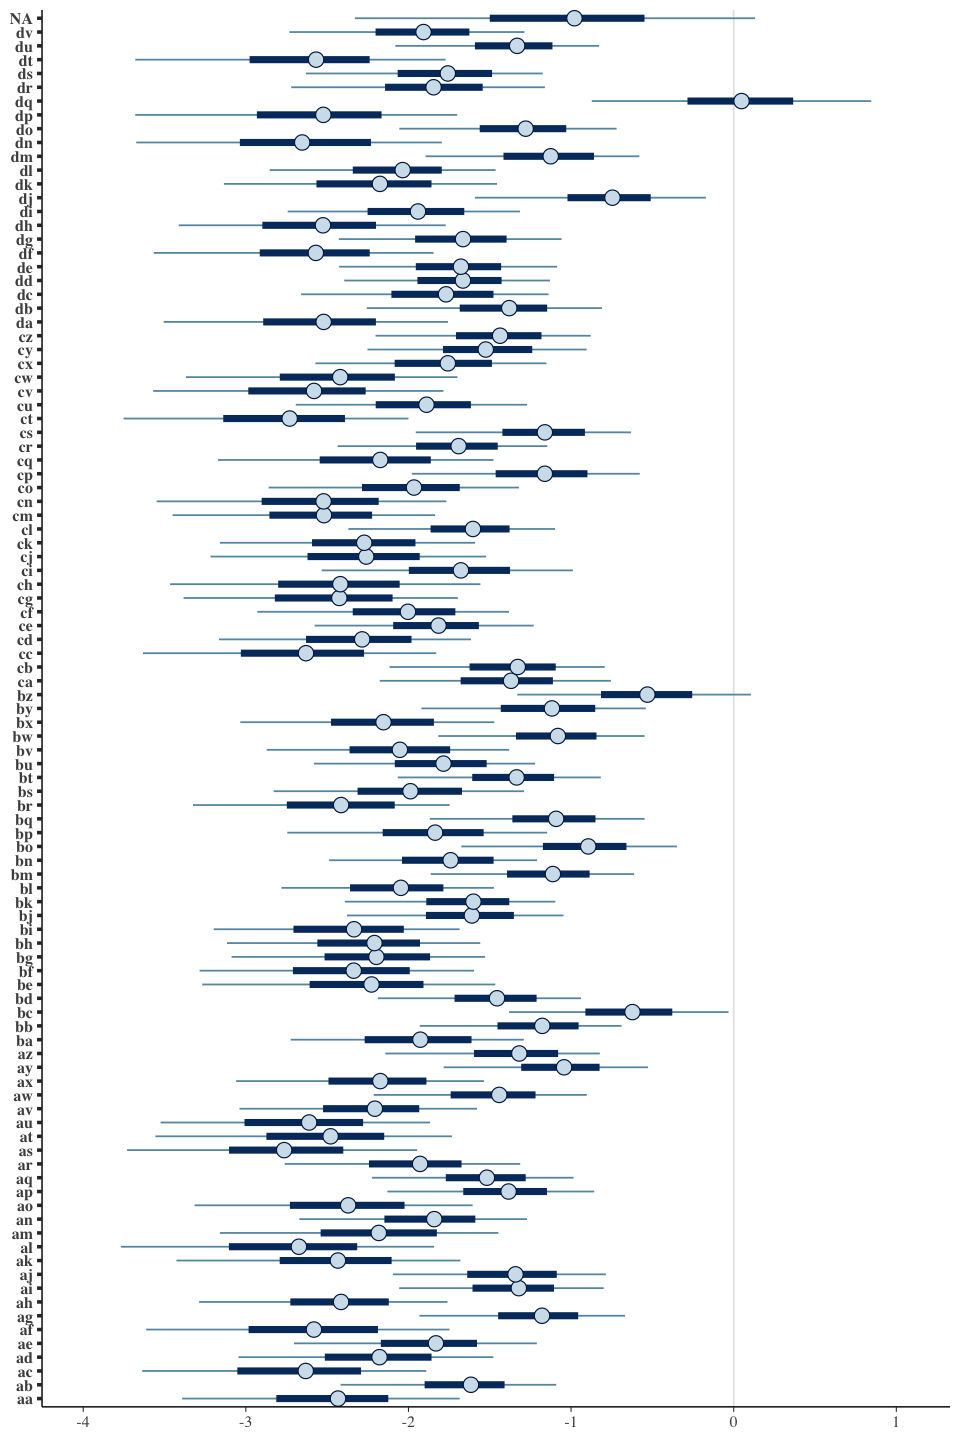

In [30]:
options(repr.plot.width = 8, repr.plot.height = 12)

beta <- as.matrix(fm, regex_pars = "R\\|int")
b <- as.matrix(fm, regex_pars = "R\\|b\\[int")
mat <- sweep(b, MARGIN=1, STATS = beta, FUN = "+")

bayesplot::mcmc_intervals(mat) + scale_y_discrete(labels=fm$groups)

In [31]:
b1_epi = apply(mat, 2, mean)

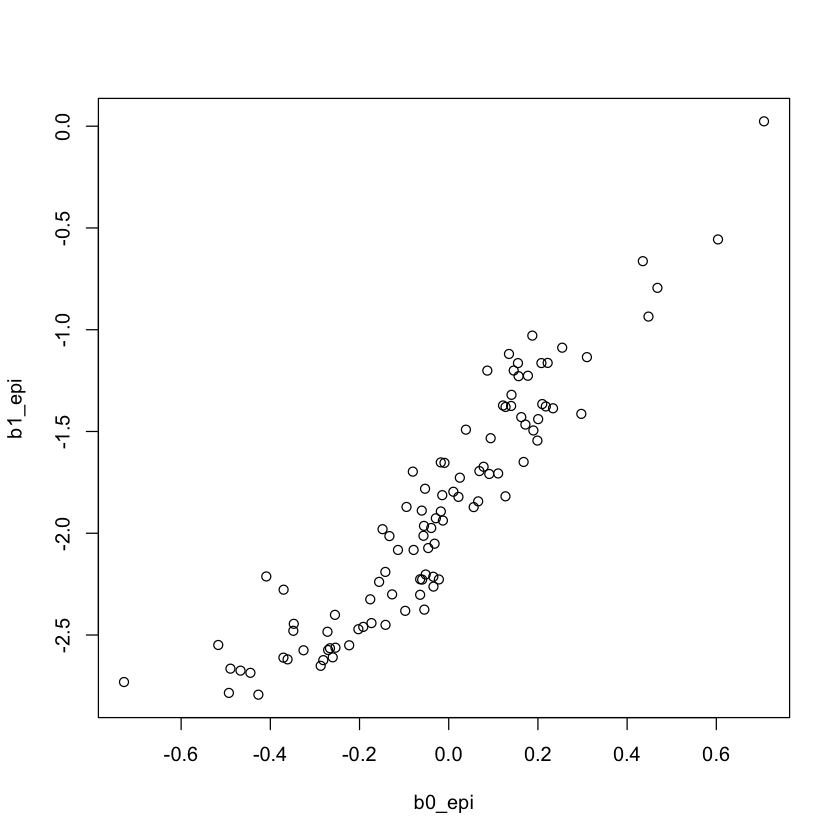

In [32]:
options(repr.plot.width = 7, repr.plot.height = 7)
plot(b0_epi, b1_epi)